In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import bout.clustering as clstr
import bout.assembly as bt
import bout.plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)
        
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

In [5]:
site_key = 'Carp'
freq_key = 'LF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[22])
file_path

PosixPath('../data/audiomoth_recordings/recover-20220901/Carp/20220901_033000.WAV')

In [6]:
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1795
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '4of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [7]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics_LF = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

In [8]:
file_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_end = file_start + dt.timedelta(minutes=30)
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_start)&(dc_applied_df['call_end_time']<=file_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

In [9]:
bout_metrics_LF.loc[(bout_metrics_LF['start_time_of_bout']>=file_start)&(bout_metrics_LF['end_time_of_bout']<=(file_start+pd.Timedelta(hours=1)))]

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
13808,2022-09-01 03:30:10.494500000,2022-09-01 03:30:15.724300,10.4945,15.7243,10.4945,15.7243,22890.0,33450.0,LF,2022-09-01 03:30:00,2022-09-01 03:30:00,23,0 days 00:00:05.229800,5.2298
13809,2022-09-01 03:30:43.328500000,2022-09-01 03:33:49.415500,43.3285,229.4155,43.3285,229.4155,21171.0,38619.0,LF,2022-09-01 03:30:00,2022-09-01 03:30:00,856,0 days 00:03:06.087000,186.0870
13810,2022-09-01 03:33:51.952500000,2022-09-01 03:33:59.389700,231.9525,239.3897,231.9525,239.3897,22890.0,32352.0,LF,2022-09-01 03:30:00,2022-09-01 03:30:00,16,0 days 00:00:07.437200,7.4372
13811,2022-09-01 03:36:00.079500000,2022-09-01 03:39:59.943200,0.0795,239.9432,360.0795,599.9432,21171.0,39226.0,LF,2022-09-01 03:36:00,2022-09-01 03:36:00,1671,0 days 00:03:59.863700,239.8637
13812,2022-09-01 03:42:00.016500000,2022-09-01 03:45:59.911000,0.0165,239.9110,720.0165,959.9110,21171.0,40380.0,LF,2022-09-01 03:42:00,2022-09-01 03:42:00,1931,0 days 00:03:59.894500,239.8945
13813,2022-09-01 03:48:00.172500000,2022-09-01 03:51:59.905600,0.1725,239.9056,1080.1725,1319.9056,22031.0,40699.0,LF,2022-09-01 03:48:00,2022-09-01 03:48:00,2052,0 days 00:03:59.733100,239.7331
13814,2022-09-01 03:54:00.047500000,2022-09-01 03:57:59.878700,0.0475,239.8787,1440.0475,1679.8787,20312.0,43880.0,LF,2022-09-01 03:54:00,2022-09-01 03:54:00,2293,0 days 00:03:59.831200,239.8312
13815,2022-09-01 04:00:00.129500000,2022-09-01 04:03:59.999000,0.1295,239.9990,0.1295,239.9990,21171.0,39745.0,LF,2022-09-01 04:00:00,2022-09-01 04:00:00,1969,0 days 00:03:59.869500,239.8695
13816,2022-09-01 04:06:00.009500000,2022-09-01 04:09:59.970800,0.0095,239.9708,360.0095,599.9708,20312.0,46503.0,LF,2022-09-01 04:06:00,2022-09-01 04:06:00,2369,0 days 00:03:59.961300,239.9613
13817,2022-09-01 04:12:00.507499999,2022-09-01 04:15:06.910700,0.5075,186.9107,720.5075,906.9107,22031.0,45808.0,LF,2022-09-01 04:12:00,2022-09-01 04:12:00,1733,0 days 00:03:06.403200001,186.4032


In [10]:
plot_bouts = bout_metrics_LF.loc[(bout_metrics_LF['start_time_of_bout']>=file_start)&(bout_metrics_LF['end_time_of_bout']<=file_end)]

In [11]:
plot_bouts

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
13808,2022-09-01 03:30:10.494500,2022-09-01 03:30:15.724300,10.4945,15.7243,10.4945,15.7243,22890.0,33450.0,LF,2022-09-01 03:30:00,2022-09-01 03:30:00,23,0 days 00:00:05.229800,5.2298
13809,2022-09-01 03:30:43.328500,2022-09-01 03:33:49.415500,43.3285,229.4155,43.3285,229.4155,21171.0,38619.0,LF,2022-09-01 03:30:00,2022-09-01 03:30:00,856,0 days 00:03:06.087000,186.0870
13810,2022-09-01 03:33:51.952500,2022-09-01 03:33:59.389700,231.9525,239.3897,231.9525,239.3897,22890.0,32352.0,LF,2022-09-01 03:30:00,2022-09-01 03:30:00,16,0 days 00:00:07.437200,7.4372
13811,2022-09-01 03:36:00.079500,2022-09-01 03:39:59.943200,0.0795,239.9432,360.0795,599.9432,21171.0,39226.0,LF,2022-09-01 03:36:00,2022-09-01 03:36:00,1671,0 days 00:03:59.863700,239.8637
13812,2022-09-01 03:42:00.016500,2022-09-01 03:45:59.911000,0.0165,239.9110,720.0165,959.9110,21171.0,40380.0,LF,2022-09-01 03:42:00,2022-09-01 03:42:00,1931,0 days 00:03:59.894500,239.8945
13813,2022-09-01 03:48:00.172500,2022-09-01 03:51:59.905600,0.1725,239.9056,1080.1725,1319.9056,22031.0,40699.0,LF,2022-09-01 03:48:00,2022-09-01 03:48:00,2052,0 days 00:03:59.733100,239.7331
13814,2022-09-01 03:54:00.047500,2022-09-01 03:57:59.878700,0.0475,239.8787,1440.0475,1679.8787,20312.0,43880.0,LF,2022-09-01 03:54:00,2022-09-01 03:54:00,2293,0 days 00:03:59.831200,239.8312


In [12]:
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] >= start, plot_bouts['end_time'] <= (start+duration))]

## The bout below ends at 3:59:54.88 and the next bout starts at 4:00:00.1295. Why is there a gap if it seems like the activity is continuous?

### Because the Audiomoths have a 5-sec sleep requirement. This "breaks" bouts from being > 29 minutes 55 seconds because all BCIs are < 5 seconds.

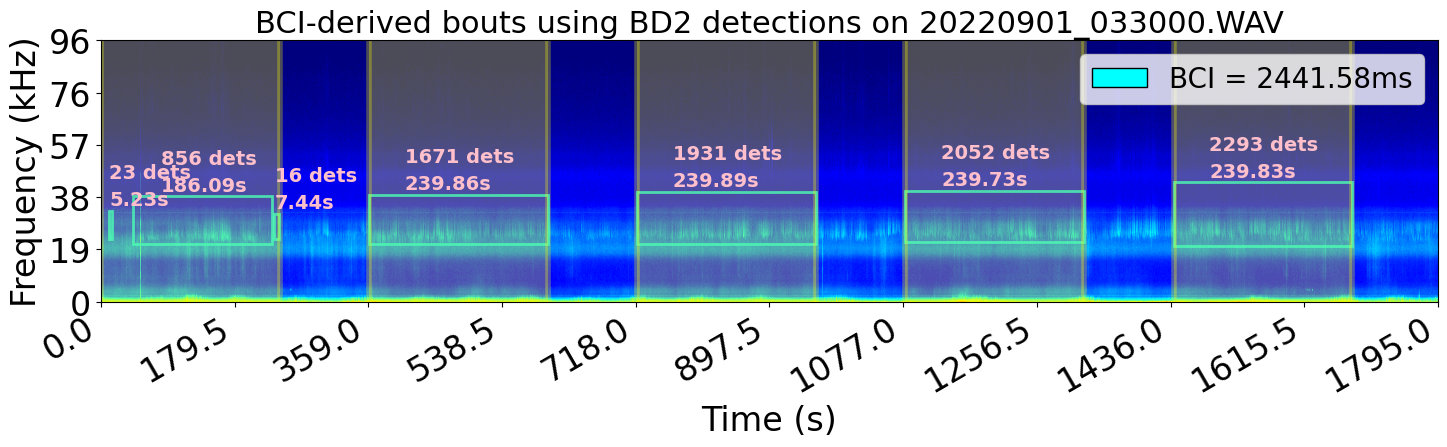

In [13]:
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [14]:
site_key = 'Carp'
freq_key = 'LF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[23])
file_path

PosixPath('../data/audiomoth_recordings/recover-20220901/Carp/20220901_040000.WAV')

In [15]:
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1795
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [16]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics_LF = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

In [17]:
file_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_end = file_start + dt.timedelta(minutes=30)
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_start)&(dc_applied_df['call_end_time']<=file_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

In [18]:
plot_bouts = bout_metrics_LF.loc[(bout_metrics_LF['start_time_of_bout']>=file_start)&(bout_metrics_LF['end_time_of_bout']<=file_end)]

In [19]:
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] >= start, plot_bouts['end_time'] <= (start+duration))]

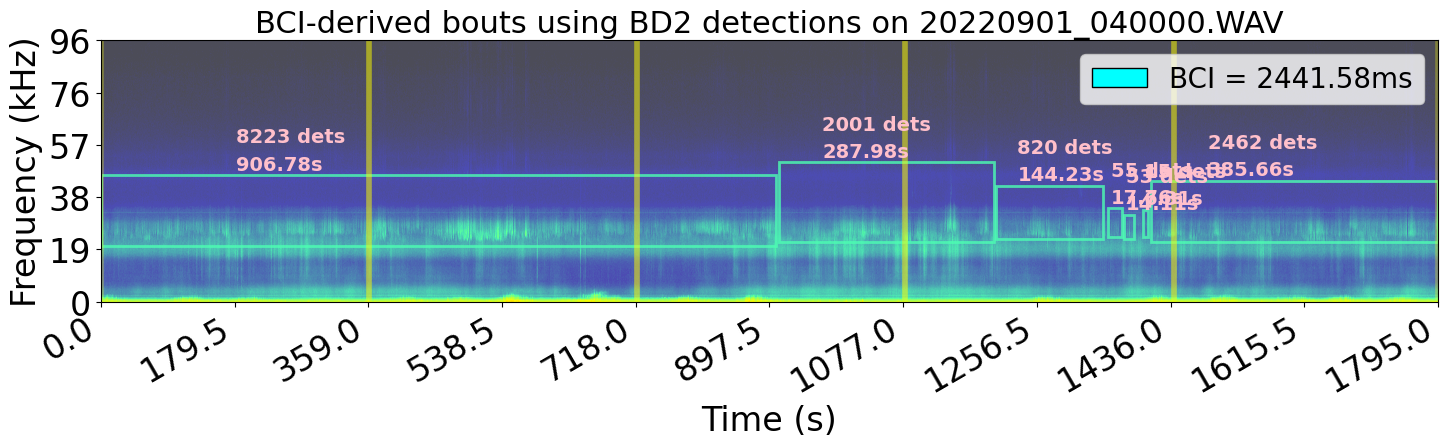

In [20]:
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [21]:
site_key = 'Carp'
freq_key = 'HF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[24])
file_path

PosixPath('../data/audiomoth_recordings/recover-20220919/Carp/20220918_043000.WAV')

In [22]:
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 300
duration = 120
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [23]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)

In [24]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics_HF = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

In [26]:
file_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_end = file_start + dt.timedelta(minutes=30)
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_start)&(dc_applied_df['call_end_time']<=file_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

In [27]:
plot_bouts = bout_metrics_HF.loc[(bout_metrics_HF['start_time_of_bout']>=file_start)&(bout_metrics_HF['end_time_of_bout']<=file_end)]
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] >= start, plot_bouts['end_time'] <= (start+duration))]

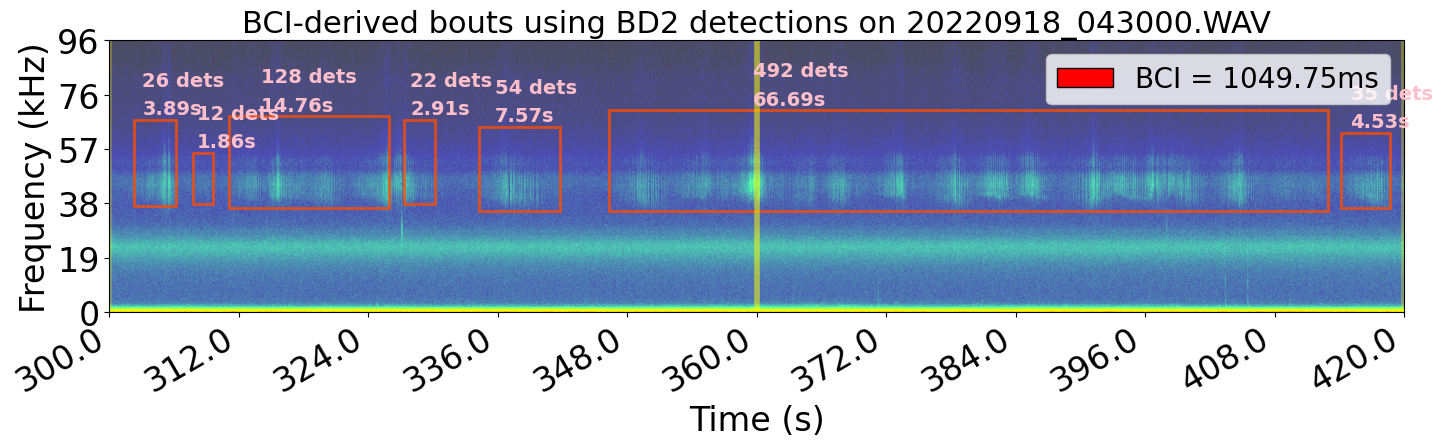

In [28]:
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)